# HW6_xy1002 developed from fbb scheleton notebook 

In [33]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import numpy as np
import pylab as pl
import os
import json
import datetime
import zipfile
import statsmodels.api as sm 
import statsmodels.formula.api as smf

#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


## An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
## So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

## Either obtain the data through the API or download the csv file, and move it to $PUIDATA

## However this datasets does not have the number of units. We can find that in the Pluto dataset.

## Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [30]:
#download, and move data to PUIDATA, and read data in 
!curl -O 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv'
os.system("mv rows.csv " + os.getenv("PUIDATA")) 
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + '/' + 'rows.csv')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3110k    0 3110k    0     0  7347k      0 --:--:-- --:--:-- --:--:-- 14.1M


In [29]:
!curl -O "https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip"
# http://stackoverflow.com/questions/3451111/unzipping-files-in-python
os.system("mv mn_mappluto_16v1.zip " + os.getenv("PUIDATA")) 
zf = zipfile.ZipFile(os.getenv("PUIDATA") + '/' + "mn_mappluto_16v1.zip")
zf.extractall(os.getenv("PUIDATA") + '/' + "Manhattan")
zf.close
bsize = gp.read_file(os.getenv("PUIDATA") + '/' + 'Manhattan/MNMapPLUTO.shp')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.6M  100 11.6M    0     0  24.4M      0 --:--:-- --:--:-- --:--:-- 37.5M


In [7]:
nrg.columns

Index(['NYC Borough, Block, and Lot (BBL)', 'Co-reported BBL Status',
       'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'],
      dtype='object')

In [140]:
nrg1 = nrg[['NYC Borough, Block, and Lot (BBL)', 'Zip Code', 'Site EUI(kBtu/ft2)',\
            'DOF Property Floor Area (Buildngs and Parking)(ft2)', 'Reported Property Floor Area (Building(s)) (ft²)',\
            'DOF Number of Buildings', 'ENERGY STAR Score']]

nrg1.rename(columns={'NYC Borough, Block, and Lot (BBL)': 'BBL'}, inplace=True)
nrg1.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,BBL,Zip Code,Site EUI(kBtu/ft2),DOF Property Floor Area (Buildngs and Parking)(ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Number of Buildings,ENERGY STAR Score
Record Number,,,,,,,
12086,1.000410e+09,NaN,NaN,NaN,918919,NaN,Not Available
14354,4.021460e+09,11375.0,NaN,82730.0,NaN,1.0,NaN
12150,2.027620e+09,NaN,NaN,NaN,64200,NaN,Not Available
12590,1.006700e+09,10001.0,NaN,440360.0,NaN,1.0,NaN
15591,2.048300e+09,NaN,NaN,NaN,50000,NaN,Not Available


In [141]:
bsize.columns

Index(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'UnitsRe

In [142]:
# make sure you clean up your data and throw away columns you do not need!
bsize1 = bsize[['BBL', 'UnitsRes', 'UnitsTotal']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d36d80c18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d375fd2b0>]], dtype=object)

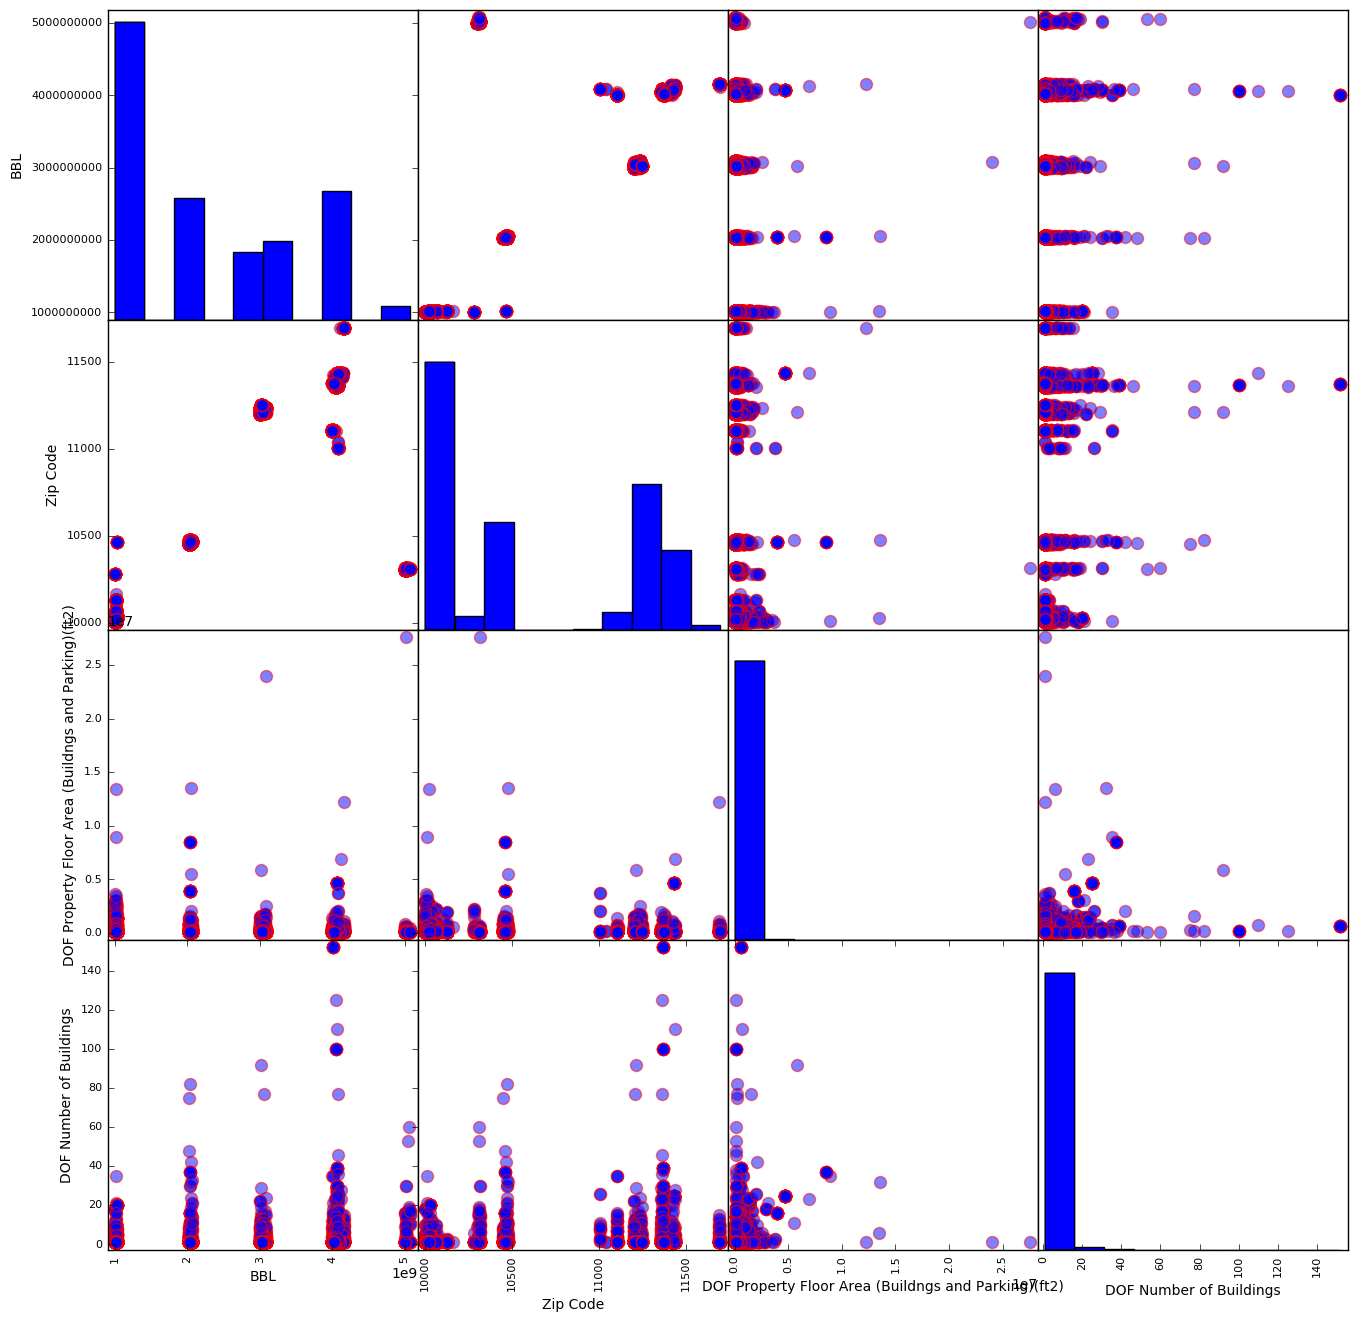

In [11]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg1, s=300, alpha = 0.5, figsize=(16, 16),color = 'red')

**Figure 1: scatter matrix of all numerical values in the files.**

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.
Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.
This has to be done entry by entry: if you give it a series you get error "cannot convert the series to..."
However you can pass it a whole array by using it in conjunction with np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [12]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
        


Now for every column I care about I can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that I want to use from my arrays of interest. 

I can replace the entries that failed to be converted to 'NaN'
(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx) 

In [13]:
#example
index = (np.vectorize(canconvert)(nrg1['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(index))
nrg1['Site EUI(kBtu/ft2)'][~index] = float('NaN')
#do it for however many columns you need


invalid entries changed to NaN 15513


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, se

In [146]:
# the method in the uppers cell didn't convert those values that are not NaN, don't know why. So we figured to use 
# another way to convert value to float. 
# Credit to John,jt2276
nrg1['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg1['Site EUI(kBtu/ft2)'], errors = 'coerce')
nrg1['Reported Property Floor Area (Building(s)) (ft²)'] = \
                         pd.to_numeric(nrg1['Reported Property Floor Area (Building(s)) (ft²)'], errors = 'coerce')
bsize1['BBL'] = pd.to_numeric(bsize1['BBL'], errors = 'coerce')

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [147]:
##check that your conversion worked: e.g.
print (nrg1['Site EUI(kBtu/ft2)'].astype(float))
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
bsize1.BBL.astype(float)
#this should not return an error
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


Record Number
12086      NaN
14354      NaN
12150      NaN
12590      NaN
15591      NaN
12135      NaN
8523       NaN
15920      NaN
14241      NaN
15925      NaN
9685       NaN
7540       NaN
14360      NaN
10588      NaN
14423      NaN
12515      NaN
3028     125.4
14609      NaN
12096      NaN
6666       NaN
8914       NaN
11586      NaN
11714      NaN
14307      NaN
12761      NaN
12091      NaN
16027      NaN
13378      NaN
14911      NaN
15103      NaN
         ...  
14559      NaN
14560      NaN
14748      NaN
14753      NaN
13582      NaN
13947      NaN
14777      NaN
14779      NaN
14409      NaN
13262      NaN
13261      NaN
12523      NaN
12529      NaN
12536      NaN
13929      NaN
13944      NaN
13945      NaN
13821      NaN
13829      NaN
13837      NaN
13838      NaN
13847      NaN
14352      NaN
12976      NaN
12978      NaN
12984      NaN
12987      NaN
12988      NaN
13472      NaN
13482      NaN
Name: Site EUI(kBtu/ft2), dtype: float64


0        1.015450e+09
1        1.007238e+09
2        1.016800e+09
3        1.013850e+09
4        1.011970e+09
5        1.002360e+09
6        1.008370e+09
7        1.001960e+09
8        1.022240e+09
9        1.011270e+09
10       1.011650e+09
11       1.021740e+09
12       1.009120e+09
13       1.007920e+09
14       1.012110e+09
15       1.011240e+09
16       1.009040e+09
17       1.010090e+09
18       1.020620e+09
19       1.020630e+09
20       1.008940e+09
21       1.005728e+09
22       1.004400e+09
23       1.019470e+09
24       1.008830e+09
25       1.020810e+09
26       1.021610e+09
27       1.008570e+09
28       1.008830e+09
29       1.020410e+09
             ...     
42667    1.014738e+09
42668    1.006208e+09
42669    1.007218e+09
42670    1.013428e+09
42671    1.019448e+09
42672    1.017298e+09
42673    1.018488e+09
42674    1.005008e+09
42675    1.020448e+09
42676    1.004518e+09
42677    1.020958e+09
42678    1.007688e+09
42679    1.008498e+09
42680    1.017298e+09
42681    1

# MERGE THE DATASET
TO DO IT WE NEED A COMMON COLUMN: the building id BBL However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

In [148]:
# prepare your BBL columns
# I did rename the column in the first few rows
#merge
bblnrgdata = pd.merge(nrg1, bsize1, how='inner', on =['BBL'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d3760bb70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d3635fc50>]], dtype=object)

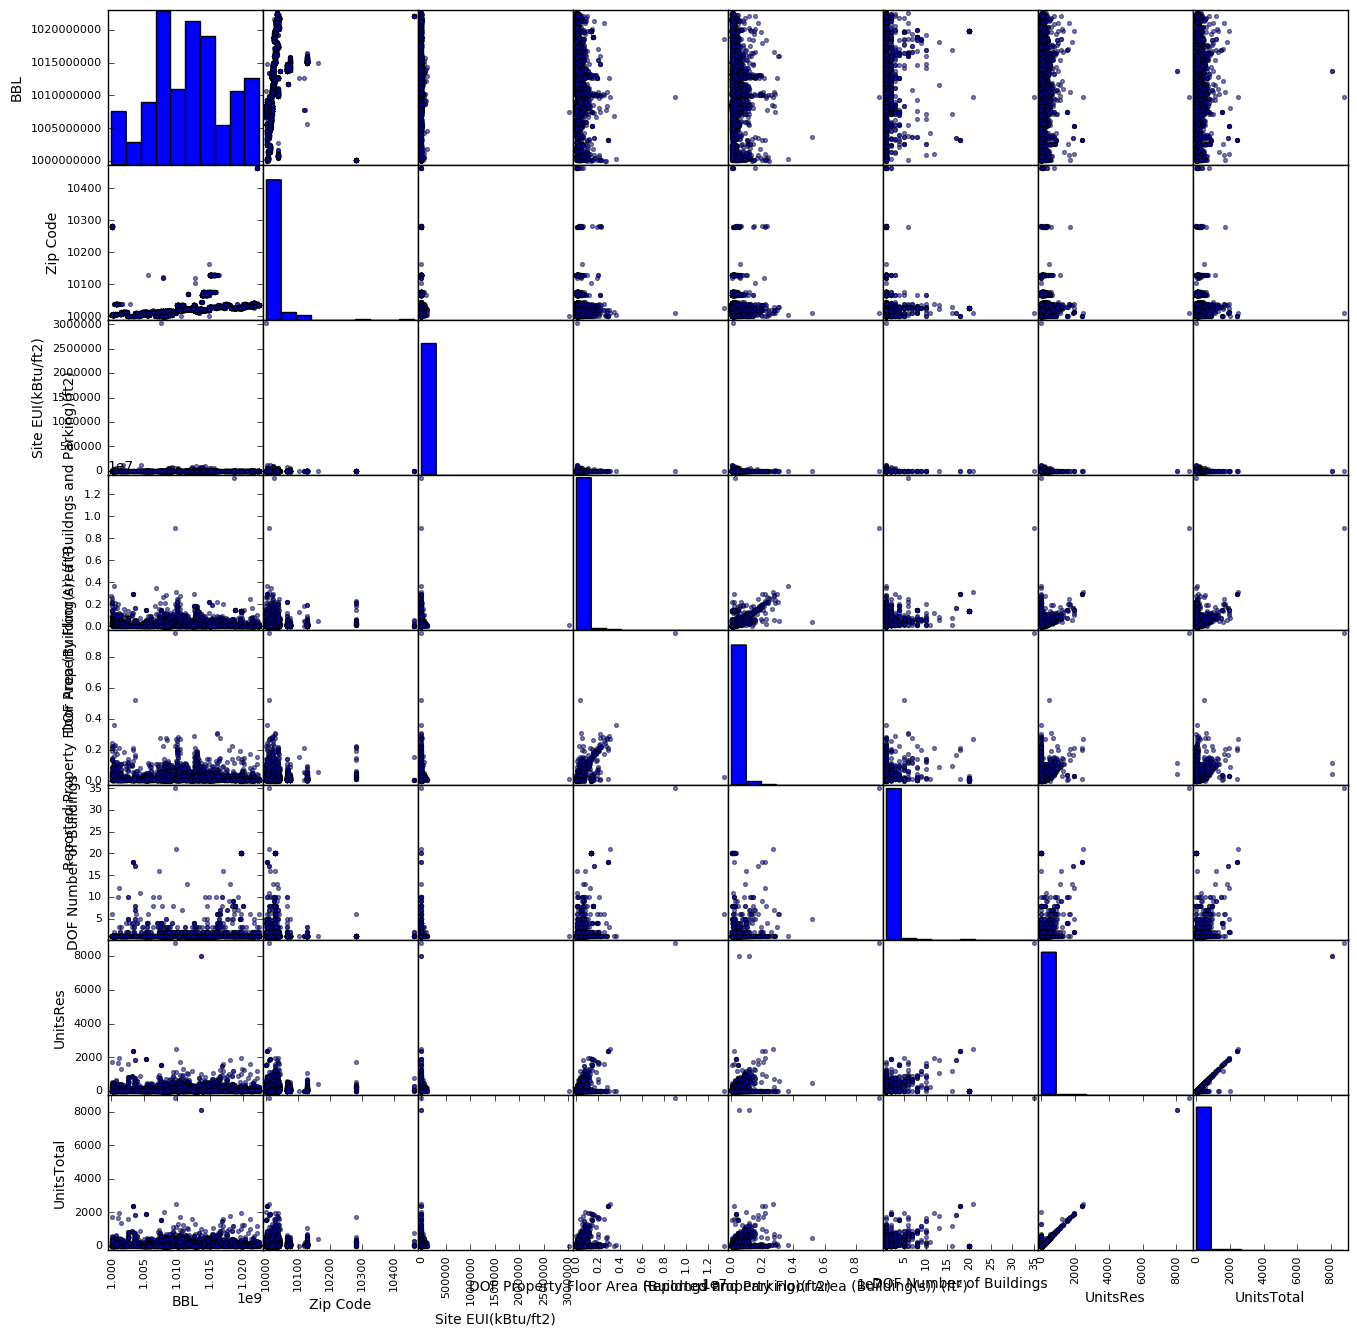

In [16]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))

**Figure 2: scatter matrix of all numerical values in the files after merge.**

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building. Remember: **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [149]:

bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)*\
                    bblnrgdata['Site EUI(kBtu/ft2)']


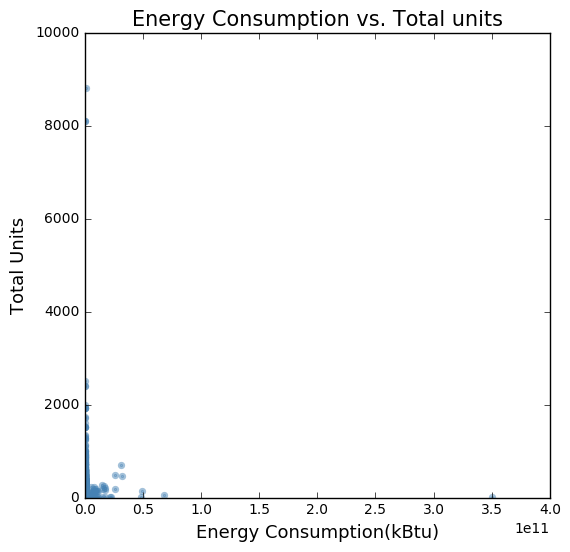

In [150]:
# first scatter plot
pl.figure(figsize=(6,6))
pl.xlim (0, 4e11)
pl.ylim (0, 10000)
pl.scatter(bblnrgdata['nrg'], bblnrgdata['UnitsTotal'],linewidth= 3, s=5, alpha = 0.5, color = 'steelblue')
pl.xlabel('Energy Consumption(kBtu)', fontsize = 13)
pl.ylabel('Total Units', fontsize = 13)
pl.title('Energy Consumption vs. Total units', fontsize = 15)

**Figure 3: Scatter of Energy Consumption(kBtu) over Total Units.**

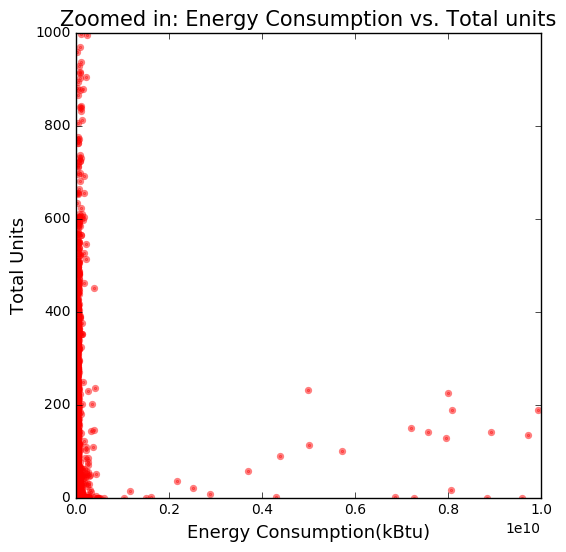

In [152]:
# zoomed in scatter plot
pl.figure(figsize=(6,6))
pl.xlim (1000,1e10)
pl.ylim (1,1000)
pl.scatter(bblnrgdata['nrg'], bblnrgdata['UnitsTotal'],linewidth= 3, s=5, alpha = 0.5, color = 'red')
pl.xlabel('Energy Consumption(kBtu)', fontsize = 13)
pl.ylabel('Total Units', fontsize = 13)
pl.title('Zoomed in: Energy Consumption vs. Total units', fontsize = 15)

**Figure 4: Zoomed Scatter of Energy Consumption(kBtu) over Total Units.**

when the points in a plot all look scrunched against the axis 

**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



In [153]:
#I cut those data which energy consumption is less than 1000 and total units less than 1
bblnrgdata_cut = bblnrgdata[(bblnrgdata.nrg > 1000) & (bblnrgdata.UnitsTotal > 1)]

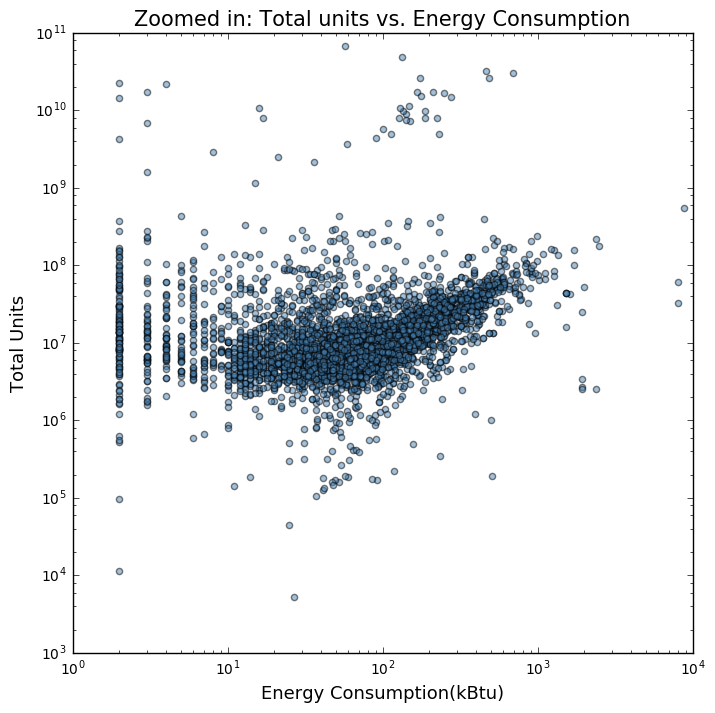

In [178]:
#log plot 
bblnrgdata_cut.plot('UnitsTotal','nrg',kind='scatter',figsize=(8, 8), alpha = 0.5, color = 'steelblue', loglog=True)
pl.xlabel('Energy Consumption(kBtu)', fontsize = 13)
pl.ylabel('Total Units', fontsize = 13)
pl.title('Zoomed in: Total units vs. Energy Consumption', fontsize = 15)

**Figure 5: Log plot of Total Units over Energy Consumption(kBtu).**

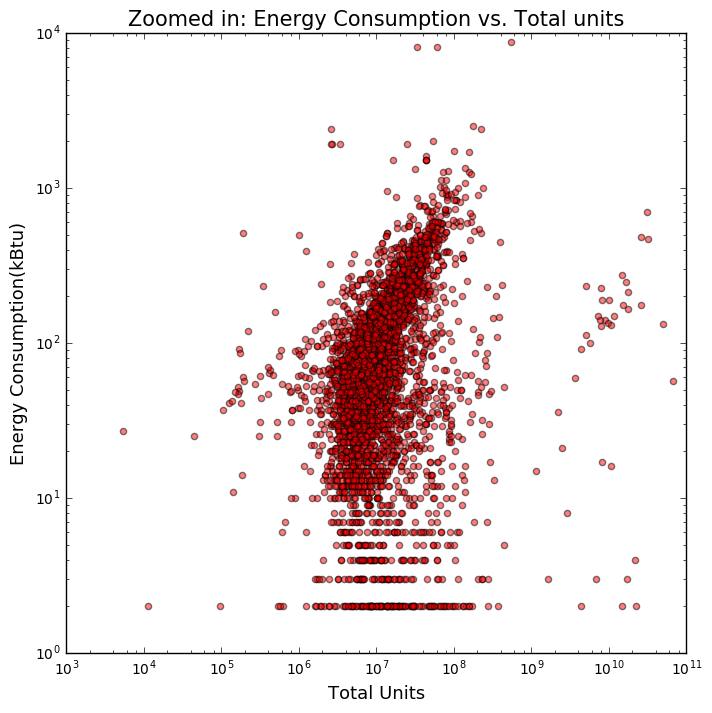

In [179]:
bblnrgdata_cut.plot('nrg','UnitsTotal',kind='scatter',figsize=(8, 8), alpha = 0.5, color = 'red', loglog=True)
pl.ylabel('Energy Consumption(kBtu)', fontsize = 13)
pl.xlabel('Total Units', fontsize = 13)
pl.title('Zoomed in: Energy Consumption vs. Total units', fontsize = 15)

**Figure 6: Log plot of Energy Consumption(kBtu) over Total Units.**

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:



X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN

## choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which variable has a 'sensible' distribution that allows you to fit a function to it: **you need your independent variable to span a large range, and to be spread somewhat evenly in the range, rather than just clustered in a spot** so in this case switching the independent and dependent variable may be a good idea.



1. **Fit a line** to Units vs Energy.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**. I provide a function for that or you can write your own. *Assume poisson statistics for the errors on the independent variable*. 
    The function is 
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value with x value $x_i$ model is the predction of your fit for $x_i$, 
    
    $data(x_i)$ 
    is your observation, 
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors??)
    
4. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2+bx+c$ .

5. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2)
    
    where Model1 is the least complex (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels.
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



In [156]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)

# 1.Fit a line to Units vs Energy.
log_nrg = np.log10(bblnrgdata_cut['nrg'])
log_tunits = np.log10(bblnrgdata_cut['UnitsTotal'])
X1 = sm.add_constant(log_tunits)
linmodel_1 = sm.OLS(log_nrg, X1).fit() # ignores entires where x or y is NaN

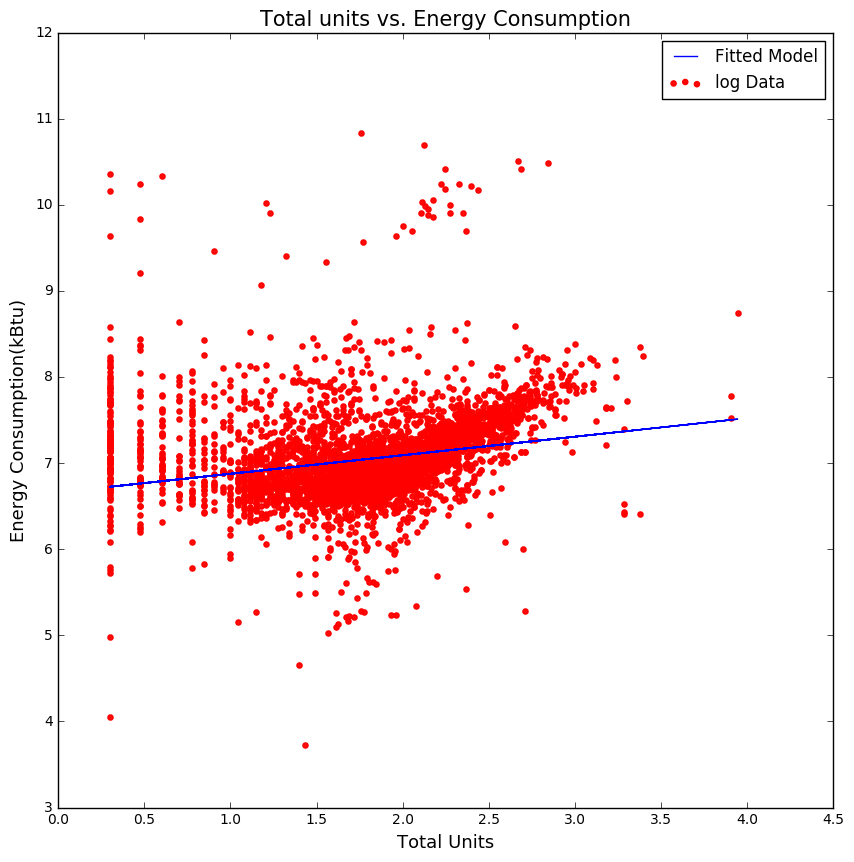

In [157]:
#plot fited model for Units vs Energy.
pl.figure(figsize=(10,10))
pl.scatter(log_tunits, log_nrg, linewidth= 3, s=3, color = 'red', label = 'log Data')
pl.plot(log_tunits, linmodel_1.predict(X1), label = 'Fitted Model')
pl.ylabel('Energy Consumption(kBtu)', fontsize = 13)
pl.xlabel('Total Units', fontsize = 13)
pl.title('Total units vs. Energy Consumption', fontsize = 15)
pl.legend()


**Figure 7: Log plot of Total Units vs Energy Consumption(kBtu) and Fited Model.**

In [158]:
#2.Fit a line to Energy vs Units.
X2 = sm.add_constant(log_nrg)
linmodel_2 = sm.OLS(log_tunits, X2, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN                       

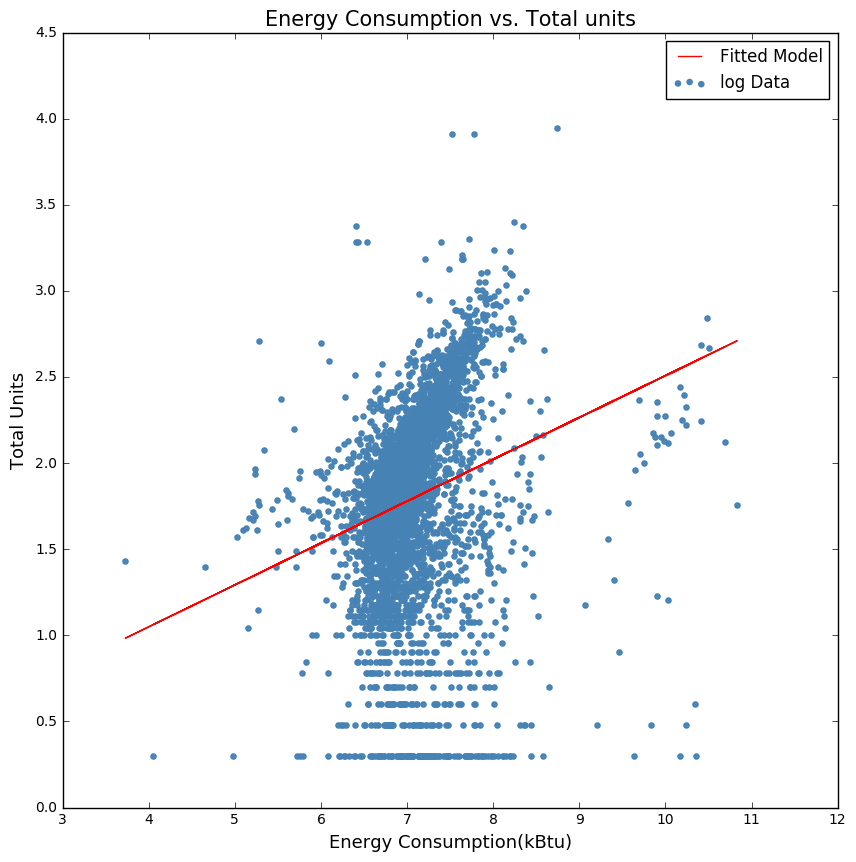

In [159]:
#Plot the fitted model for Energy vs Units.       
pl.figure(figsize=(10,10))
pl.scatter(log_nrg, log_tunits,linewidth= 3, s=3, color = 'steelblue', label = 'log Data')
pl.plot(log_nrg, linmodel_2.predict(X2), color = 'red', label = 'Fitted Model')
pl.xlabel('Energy Consumption(kBtu)', fontsize = 13)
pl.ylabel('Total Units', fontsize = 13)
pl.title('Energy Consumption vs. Total units', fontsize = 15)
pl.legend()

**Figure 8: Log plot of Energy Consumption(kBtu) vs Total Units and Fitted Model.**

In [160]:
# my OLS summary. 
# Yours may be somewhat different depending on how you cut the data
#summary of Units vs Energy model.
linmodel_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     257.4
Date:                Wed, 19 Oct 2016   Prob (F-statistic):           2.02e-56
Time:                        14:23:26   Log-Likelihood:                -3313.1
No. Observations:                4661   AIC:                             6630.
Df Residuals:                    4659   BIC:                             6643.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.6600      0.025    265.485      0.000         6.611     6.709
UnitsTotal     0.2154      0.013     16.043      0.000         0.189     0.242
==============================================================================
Omnibus:                     2206.606   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31494.767
Skew:                           1.891   Prob(JB):                         0.00
Kurtosis:                      15.160   Cond. No.                         8.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:
#summary of Energy vs Units model.
linmodel_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     257.4
Date:                Wed, 19 Oct 2016   Prob (F-statistic):           2.02e-56
Time:                        14:23:29   Log-Likelihood:                -3594.4
No. Observations:                4661   AIC:                             7193.
Df Residuals:                    4659   BIC:                             7206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0771      0.107      0.720      0.471        -0.133     0.287
nrg            0.2430      0.015     16.043      0.000         0.213     0.273
==============================================================================
Omnibus:                      706.328   Durbin-Watson:                   1.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1227.710
Skew:                          -0.987   Prob(JB):                    2.55e-267
Kurtosis:                       4.557   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
#3. Evaluate which is better by calculating the chi square.

chisq_1 = np.sum(((linmodel_1.predict(X1) - log_nrg)**2) / log_nrg )
chisq_2 = np.sum(((linmodel_2.predict(X2) - log_tunits)**2) / log_tunits)
print(chisq_1, chisq_2)

149.631710646 1858.91251209


**Conclusion: **Since the first chi square number is far less than the second one, which indicates that the first model for units vs. energy fits better. Higher chi square means that the data is far from the model. So I will choose units as my independent variable and energy consumption as my dependent variable. 

In [163]:
#4.Fit a 2nd degree polynomial
xyd = pd.DataFrame()
xyd['X'] = log_tunits
xyd['Y'] = log_nrg
xyd['X2'] = log_tunits * log_tunits

curvemodel = smf.ols(formula = 'Y ~ X2 + X ', data = xyd).fit()

In [164]:
curvemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     511.4
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          1.66e-201
Time:                        14:23:37   Log-Likelihood:                -2975.8
No. Observations:                4661   AIC:                             5958.
Df Residuals:                    4658   BIC:                             5977.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.5838      0.041    182.802      0.000         7.502     7.665
X2             0.3934      0.015     26.933      0.000         0.365     0.422
X             -1.0683      0.049    -21.681      0.000        -1.165    -0.972
==============================================================================
Omnibus:                     2265.070   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46859.344
Skew:                           1.836   Prob(JB):                         0.00
Kurtosis:                      18.093   Cond. No.                         42.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

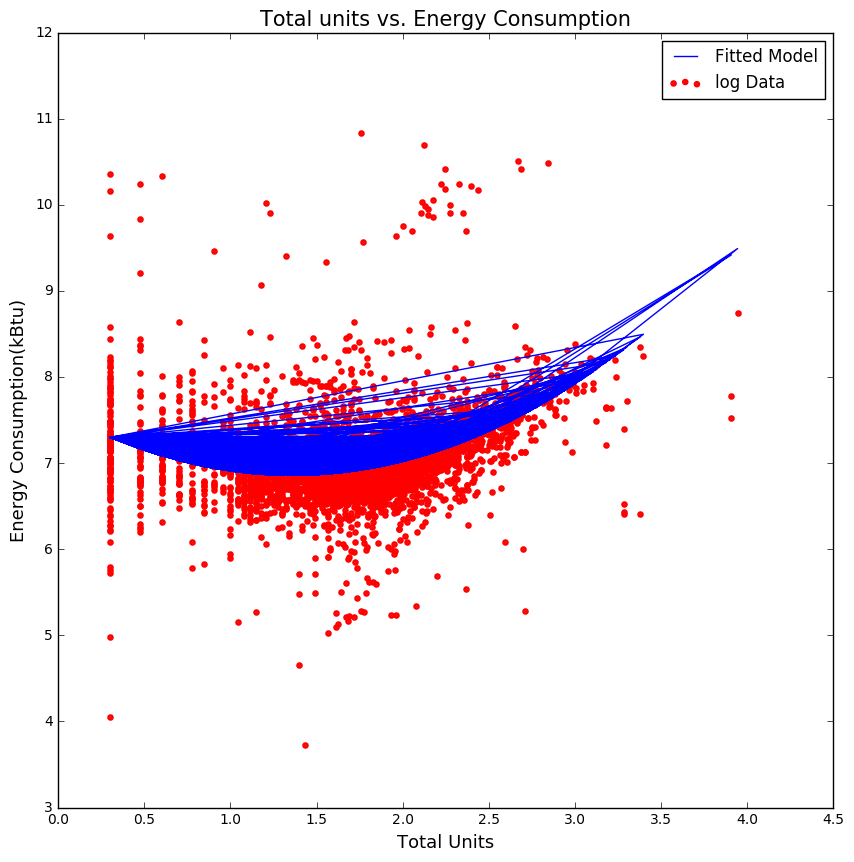

In [165]:
pl.figure(figsize=(10,10))
pl.scatter(log_tunits, log_nrg, linewidth= 3, s=3, color = 'red', label = 'log Data')
pl.plot(xyd['X'], curvemodel.predict(xyd), label = 'Fitted Model')
pl.ylabel('Energy Consumption(kBtu)', fontsize = 13)
pl.xlabel('Total Units', fontsize = 13)
pl.title('Total units vs. Energy Consumption', fontsize = 15)
pl.legend()


**Figure 9: Log plot of Total Units vs Energy Consumption(kBtu) and 2nd degree polynomial Fitted Model.**



In [166]:
print ("LR : ", -2 * (-linmodel_1.llf - (-curvemodel.llf)))
print ("LR from statsmodels:", curvemodel.compare_lr_test(linmodel_1))

LR :  -674.578937376
LR from statsmodels: (674.57893737574705, 1.0088513642778212e-148, 1.0)


**5.Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test. **

The curve model has two parameters and linear model only has one, so the DOF is 1. From the result we can see that LR = -674.57, which is far less than 3.84 according to chi sq table at alpha = 0.05. From which we can say that 2-nd degree polynomial fit is preferable to linear fit. 

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

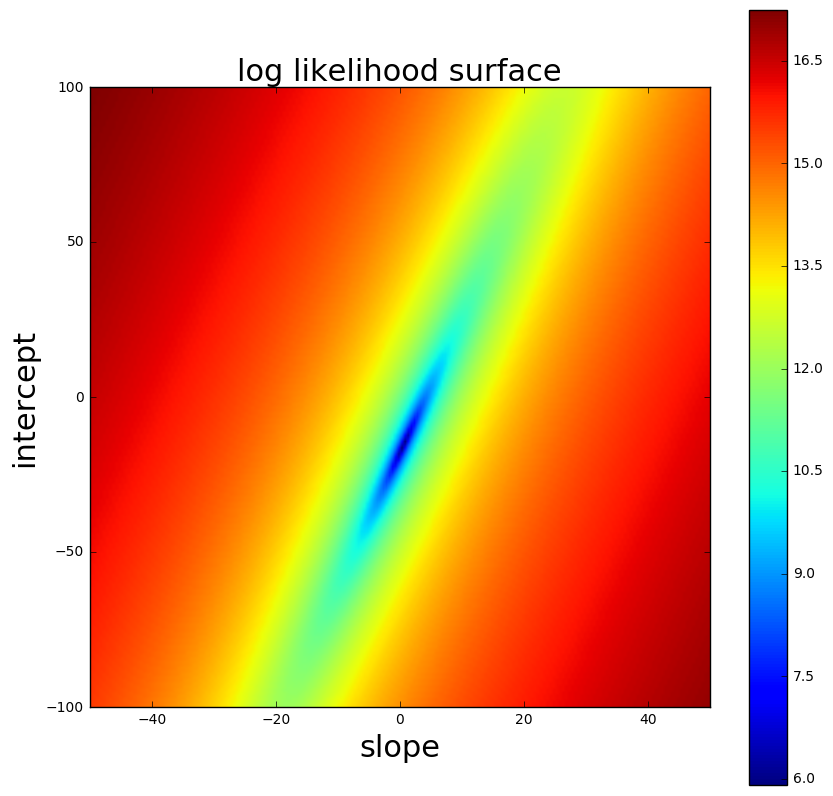

In [167]:
def residuals(a,b,data,errors):
    return (((np.log(data.UnitsTotal) * a + b) - np.log(data.nrg))**2 / errors**2)

B = np.arange (-100, 100, 1) 
A = np.arange(-50.0, 50.0, 0.5) 
Lsurface = np.zeros((len(A), len(B))) 

for i,b in enumerate(B): 
    for j,a in enumerate(A): 
        Lsurface[i][j] = np.nansum(residuals(a, b, bblnrgdata_cut, np.sqrt(np.log(bblnrgdata_cut.nrg))))
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,-100,100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

**Figure 10: Heat map for likelihood surface.**

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

Below I am mapping the **building energy score** to a colormap and the ratio of total to residential units to the size of the datapoint.

In [168]:
bblnrgdata.columns

Index(['BBL', 'Zip Code', 'Site EUI(kBtu/ft2)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Number of Buildings', 'ENERGY STAR Score', 'UnitsRes',
       'UnitsTotal', 'nrg'],
      dtype='object')

In [170]:
#covert value of energy star score to numeric value.
bblnrgdata['ENERGY STAR Score'] = pd.to_numeric(bblnrgdata['ENERGY STAR Score'], errors = 'coerce')

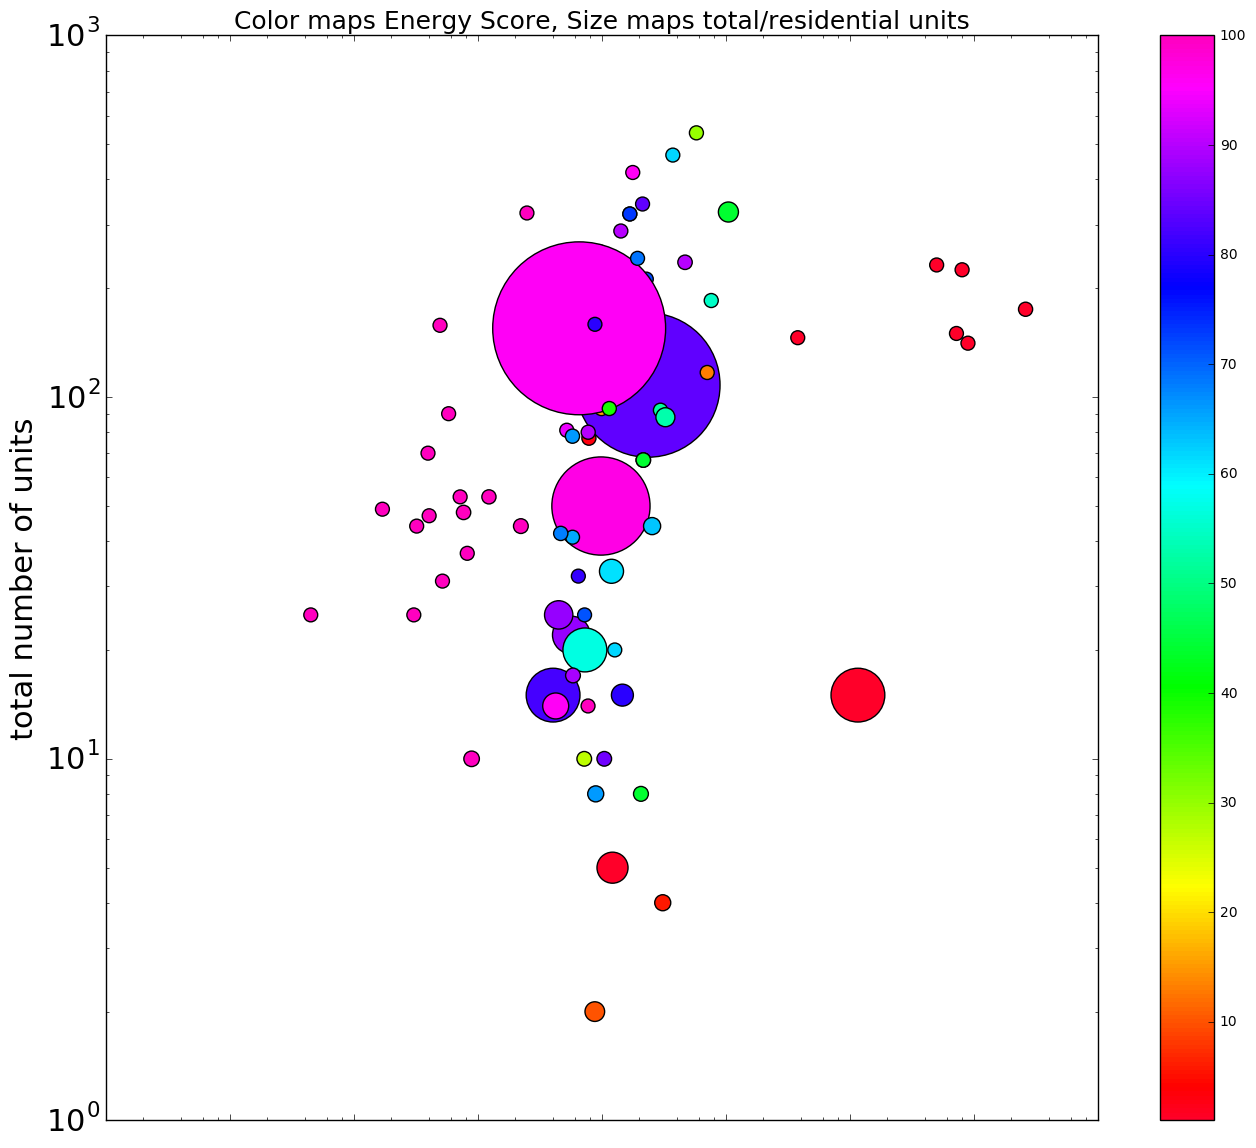

In [177]:
bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['ENERGY STAR Score'], 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Energy Score, Size maps total/residential units', fontsize=18)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)
pl.ylabel("total number of units", fontsize=22)


**Figure 11: Color maps Energy Score, Size maps total/residential units.**